# My TTN library
In this notebook I try to develop my personal library to handle TTNs, their definition, properties, automatic contraction and training.

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:

import torch
import numpy as np
import pandas as pd
import arff
from scipy.io.arff import loadarff
import matplotlib.pyplot as plt
import seaborn as sns
import skunk
from matplotlib import colormaps, patches
from sklearn.metrics import roc_auc_score, roc_curve
from timeit import timeit, repeat
from datetime import datetime
from itertools import combinations_with_replacement
from IPython.display import display, SVG
import graphviz

from ttnml.ml import TTNModel
from ttnml.tn import check_correct_init
from ttnml.tn.algebra import contract_up
from ttnml.utils import *
from torchinfo import summary

from tqdm.notebook import tqdm, trange
FONTSIZE = 14

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

np.random.seed(42)

# Tests

In [ ]:
from ttnml.tn import TTN, TTNIndex, TIndex
from typing import Sequence, ValuesView
from string import ascii_letters
from ttnml.utils.dataloaders import linearize

In [ ]:
DEVICE = 'cpu'
DTYPE = torch.double
N_FEAT = 8
ttn = TTN(N_FEAT, bond_dim=8, n_labels=2, device=DEVICE, dtype=DTYPE)
ttn.draw()

## Basic operations
General purpose contraction, not optimized

In [ ]:
def contract(
        tensors : Sequence[torch.Tensor] | ValuesView[torch.Tensor], 
        tindices: Sequence[TTNIndex | TIndex], 
        keep    : Sequence[str] | None=None, 
        outname : str | None=None
):
    """
    Contract two tensors along the matching TIndices in indices, except for the indices in keep.
    """
    if len(tindices) != len(tensors):
        raise ValueError(f"Expected tensors and tindices to have same lenght, got {len(tensors)} and {len(tindices)}")

    if keep is None:
        keep = []
    elif isinstance(keep, str):
        keep = [keep]
    elif not isinstance(keep, Sequence):
        raise TypeError(f"Expected keep to be None, str or Sequence, got {type(keep)}")

    keep = list(keep)
    unique_inds, counts = np.unique(np.concatenate([tindex.indices for tindex in tindices]), return_counts=True)
    if np.any(np.isin(keep, unique_inds, invert=True)):
        raise ValueError(f"keep contains indices that are not in tindices: {np.asarray(keep)[np.where(np.isin(keep, unique_inds, invert=True))[0]]}")
    if len(unique_inds) > len(ascii_letters):
        raise ValueError(f"Too many indices to contract: {len(unique_inds)} > {len(ascii_letters)}")

    # find output indices (all indices that are not contracted or kept)
    output_inds = unique_inds[np.isin(unique_inds, keep) | (counts == 1)]
    
    # map indices to letters
    idx_to_char_map = {tind: ascii_letters[i] for i, tind in enumerate(unique_inds)}
    
    # contraction strings
    ## tensor indices
    tindices_str = ["..."+"".join([idx_to_char_map[i] for i in tindex.indices]) for tindex in tindices] # the ellipsis is for batch dimension
    ## output indices
    outinds_str = "..."+"".join([idx_to_char_map[i] for i in output_inds])

    #print(tindices_str,'\n' ,outinds_str)
    # contract
    C = torch.einsum(f"{','.join(tindices_str)}->{outinds_str}", *tensors)

    return C, TIndex(f"{min(tindices)}" if outname is None else outname, output_inds)

    

Let's exploit the TTN topology to optimize contractions, i.e. make them go from bottom to top

In [ ]:
def contract_up_einsum(tensor: torch.Tensor, data_tensors: Sequence[torch.Tensor]):
    # this function is the fundamental block for TTN contractions:
    # it takes a ttn tensor and two data vectors and contracts them to a new vector

    return torch.einsum('bi,bj,ijk->bk', data_tensors[0], data_tensors[1], tensor)

In [ ]:
data = torch.rand(N_FEAT, 10, 2, dtype=DTYPE, device=DEVICE).unbind(0)
data_indices = [TIndex(f"{ttn.n_layers}.{i}", [f"data.{i}"]) for i in range(N_FEAT)]

time1 = timeit(lambda: contract_up(ttn.tensors[-1], data[:2]), number=10000)
time2 = timeit(lambda: contract((ttn.tensors[-1],) + data[:2], [ttn.indices[-1]]+data_indices[:2]), number=10000)
time3 = timeit(lambda: contract_up_einsum(ttn.tensors[-1], data[:2]), number=10000)
time1, time2, time3

In [ ]:
map_dim = [2, 4, 8, 16, 32]
batch_dims = [10, 100, 1000, 10000]

df_cpu = pd.DataFrame(columns=['contract_up', 'contract_up_einsum'], index=pd.MultiIndex.from_product([batch_dims, map_dim], names=['batch_dim', 'map_dim']))
df_gpu = pd.DataFrame(columns=['contract_up', 'contract_up_einsum'], index=pd.MultiIndex.from_product([batch_dims, map_dim], names=['batch_dim', 'map_dim']))

DTYPE = torch.double
DEVICE = 'cpu'
pbar = tqdm(total=len(batch_dims)*len(map_dim), desc='CPU')
for bd in batch_dims:
    for md in map_dim:
        pbar.set_postfix({'batch_dim': bd, 'map_dim': md})
        data = torch.rand(2, bd, md, dtype=DTYPE, device=DEVICE).unbind(0)
        tensor = torch.rand(md, md, 16, dtype=DTYPE, device=DEVICE)

        time1 = min(repeat(lambda: contract_up(tensor, data), number=100, repeat=10))
        time2 = min(repeat(lambda: contract_up_einsum(tensor, data), number=100, repeat=10))
        df_cpu.loc[(bd, md), 'contract_up'] = time1
        df_cpu.loc[(bd, md), 'contract_up_einsum'] = time2
        pbar.update(1)
pbar.close()

DEVICE = 'cuda'
pbar = tqdm(total=len(batch_dims)*len(map_dim), desc='GPU')
for bd in batch_dims:
    for md in map_dim:
        pbar.set_postfix({'batch_dim': bd, 'map_dim': md})
        data = torch.rand(2, bd, md, dtype=DTYPE, device=DEVICE).unbind(0)
        tensor = torch.rand(md, md, 16, dtype=DTYPE, device=DEVICE)

        time1 = min(repeat(lambda: contract_up(tensor, data), number=1000, repeat=10))
        time2 = min(repeat(lambda: contract_up_einsum(tensor, data), number=1000, repeat=10))
        df_gpu.loc[(bd, md), 'contract_up'] = time1
        df_gpu.loc[(bd, md), 'contract_up_einsum'] = time2
        pbar.update(1)
pbar.close()
        


In [ ]:
df_cpu['ratio'] = df_cpu['contract_up_einsum'] / df_cpu['contract_up']
df_gpu['ratio'] = df_gpu['contract_up_einsum'] / df_gpu['contract_up']
df_gpu['contract_up'] = df_gpu['contract_up'] / 10
df_gpu['contract_up_einsum'] = df_gpu['contract_up_einsum'] / 10

In [ ]:
df_cpu.pivot_table(index='map_dim', columns='batch_dim', values='ratio')

In [ ]:
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)

sns.lineplot(data=df_cpu, x='map_dim', y='ratio', ax=axes[0], hue='batch_dim', palette='tab10')
sns.lineplot(data=df_gpu, x='map_dim', y='ratio', ax=axes[1], hue='batch_dim', palette='tab10')
axes[0].hlines(1, 2, 32, colors='k', linestyles='dashed', label='1')
axes[1].hlines(1, 2, 32, colors='k', linestyles='dashed', label='1')

axes[0].set_xscale('log')
axes[0].set_xticks(map_dim, map_dim, fontsize=FONTSIZE-2)
axes[0].set_title('CPU', fontsize=FONTSIZE+2)
axes[1].set_title('GPU', fontsize=FONTSIZE+2)
axes[0].set_ylabel('Speedup', fontsize=FONTSIZE)
axes[0].set_xlabel('Bond dimension', fontsize=FONTSIZE)
axes[1].set_xlabel('Bond dimension', fontsize=FONTSIZE)
fig.suptitle('Speedup of matmul over einsum', fontsize=FONTSIZE+4)
fig.tight_layout()
fig.show()
fig.savefig('images/speedup_matmul_einsum2.pdf')

In [ ]:
data = torch.rand(N_FEAT, 64, 2, dtype=DTYPE, device=DEVICE).unbind(0)
data_indices = [TIndex(f"data.{i}", [f"data.{i}"]) for i in range(N_FEAT)]
i=1
time1 = timeit(lambda: ttn._propagate_data_through_branch_(dict(zip(data_indices, data)), ttn.get_branch('1.0')), number=100)
time2 = timeit(lambda: ttn._propagate_data_through_branch_(dict(zip(data_indices, data)), ttn.get_branch('1.0'), keep=True), number=100)
time3 = timeit(lambda: contract(list(ttn.get_branch(f'1.{i}').values()) + list(data[16*i:16*(i+1)]), list(ttn.get_branch(f'1.{i}').keys())+data_indices[16*i:16*(i+1)]), number=100)
print(time1, time2, time3)

TEST the contraction scheme by a synthetic dataset and the TTN initialized to identities

In [ ]:
def generate_i_state(n_sites, i, dtype=torch.double):
    """
    Generates a separable state wich would be represented 
    as a vector with 1 at i-th position in the full form.
    """
    sites = []
    bin_str = f'{i:b}'
    bin_str = '0'*(n_sites-len(bin_str)) + bin_str
    for char in bin_str:
        if char == '0':
            sites.append(torch.as_tensor([1.0, 0.0], dtype=dtype))
        else:
            sites.append(torch.as_tensor([0.0, 1.0], dtype=dtype))
 
    state = torch.stack(sites)

    return state


# create general purpose identity tensor
# this is a 3d tensor with 1 on the diagonal
ID = torch.zeros([4, 4, 4], dtype=DTYPE)
for i in range(ID.shape[0]):
    ID[i, i, i] = 1.0
# create data
# you can choose from different states
I = 0 # position of 1 in the resulting state (starting from 0)
test_states = {'up': [1, 0], 'down': [0, 1], 'plus': [1/(2**0.5), 1/(2**0.5)], 'minus': [1/(2**0.5), -1/(2**0.5)], 'i': generate_i_state(N_FEAT, I)}
data = torch.expand_copy(torch.as_tensor(test_states['i'], dtype=DTYPE), [64, N_FEAT, 2])

# transform to data dictionary to pass to _propagate_data_through_branch_
data_dict = {TIndex(f"data.{i}", [f"data.{i}"]): datum for i, datum in enumerate(data.unbind(1))}
# set TTN tensors to identity
ttn.tensors = [torch.eye(tensor.shape[0]**2, dtype=DTYPE).reshape(*tensor.shape[:2], -1)[:,:,:tensor.shape[-1]] for tensor in ttn.tensors] #[ID[:tensor.shape[0], :tensor.shape[1], :tensor.shape[2]] for tensor in ttn.tensors]
# contract
pbar = tqdm(total=len(ttn.tensors), desc='ttn test', position=0)
result = ttn._propagate_data_through_branch_(data_dict, ttn.get_branch('0.0'), keep=True, pbar=pbar)['0.0']
pbar.close()
result[0]

In [ ]:
imsize = '16x16'

train = np.load('../data/stripeimages/' + imsize + 'train.npy')
test = np.load('../data/stripeimages/' + imsize + 'test.npy')

train_linear = linearize(torch.tensor(train)).to(dtype=torch.float32)
test_linear = linearize(torch.tensor(test)).to(dtype=torch.float32)

np.save('../data/stripeimages/' + imsize + 'train_linear.npy', train_linear)
np.save('../data/stripeimages/' + imsize + 'test_linear.npy', test_linear)

In [ ]:
plt.imshow(train[0], cmap='gray')

# Train Model

## Load data and create model

In [3]:
h = 8
features = h**2
BATCH_SIZE = 5000
DATASET = 'hls'
MAPPING = 'spin'
MAP_DIM = 2

iris_features = ['SL', 'SW', 'PL', 'PW']

if DATASET == 'mnist':
    train_dl, test_dl, train_visual, features = get_mnist_data_loaders(h, batch_size=BATCH_SIZE, mapping=MAPPING, dim=MAP_DIM, labels=[0, 1])
elif DATASET == 'stripe':
    train_dl, test_dl, features = get_stripeimage_data_loaders(4, h, batch_size=BATCH_SIZE, mapping=MAPPING, dim=MAP_DIM)
elif DATASET == 'iris':
    # worst performance with iris-versicolor and iris-virginica
    train_dl, test_dl, features = get_iris_data_loaders(batch_size=BATCH_SIZE, sel_labels=['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], mapping=MAPPING, dim=MAP_DIM)
elif DATASET == 'higgs':
    train_dl, test_dl, features = get_higgs_data_loaders(batch_size=BATCH_SIZE, mapping=MAPPING, dim=MAP_DIM)
elif DATASET == 'titanic':
    train_dl, test_dl, features = get_titanic_data_loaders(batch_size=BATCH_SIZE, scale=(0, 1), mapping=MAPPING, dim=MAP_DIM)   # scales different from (0, 1) are reasonable only in the poly mapping
elif DATASET == 'bbdata':
    train_dl, test_dl, features = get_bb_data_loaders(batch_size=BATCH_SIZE, mapping=MAPPING, dim=MAP_DIM, permutation=[0,1,5,7,10,12,13,15])#permutation=[0,1,5,7,10,12,14,15]
elif DATASET == 'hls':
    train_dl, test_dl, features = get_hls_data_loaders(batch_size=BATCH_SIZE, mapping=MAPPING, dim=MAP_DIM)
else:
    raise ValueError(f"Unknown dataset: {DATASET}")



In [4]:
len(train_dl.dataset), len(test_dl.dataset), features

(644264, 161066, 16)

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BOND_DIM = 10
N_LABELS = 5

### Normal

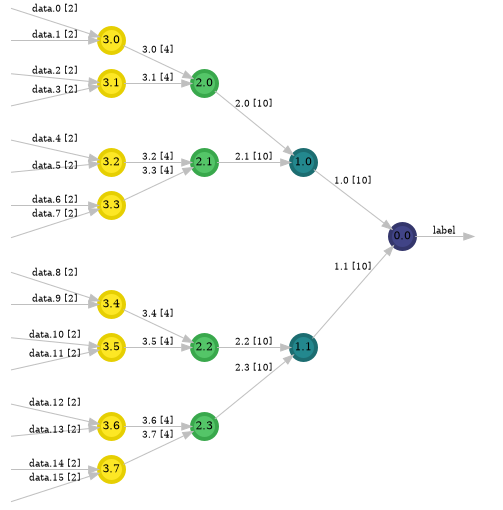

In [ ]:

DTYPE = torch.double
dtype_eps = torch.finfo(DTYPE).eps
MODEL_DIR = f'trained_models/{DATASET}_models'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

model = TTNModel(features, n_phys=MAP_DIM, bond_dim=BOND_DIM, n_labels=N_LABELS, device=DEVICE, dtype=DTYPE)
model.draw()

### Quantized

In [6]:
from qtorch import FixedPoint, FloatingPoint
from qtorch.quant import Quantizer, fixed_point_quantize
from qtorch.optim import OptimLP

wl = 16
fl = 14

forward_num = FixedPoint(wl=wl, fl=fl)
backward_num = FixedPoint(wl=wl, fl=fl)

# Create a quantizer
Q = Quantizer(forward_number=forward_num, backward_number=backward_num,
              forward_rounding="nearest", backward_rounding="nearest")


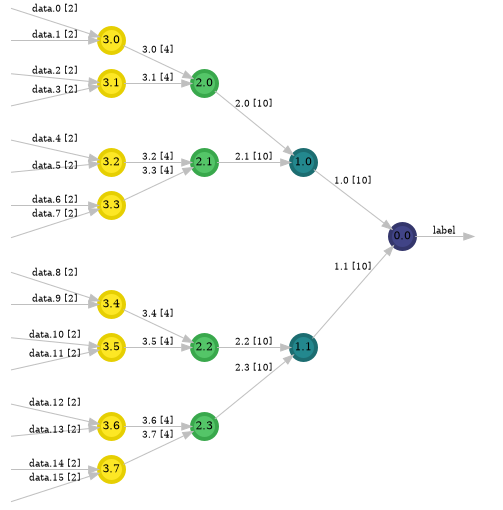

In [7]:
MODEL_DIR = f'trained_models/qmodels/{DATASET}_models'
DTYPE = torch.float      # we use float for the quantization, as qtorch does not support double
dtype_eps = torch.finfo(DTYPE).eps
if 2**(-forward_num.fl) > dtype_eps:
    dtype_eps = 2**(-forward_num.fl)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

model = TTNModel(features, bond_dim=BOND_DIM, n_labels=N_LABELS, device=DEVICE, dtype=DTYPE, quantizer=Q)
model.draw()

## Initialize

In [8]:
INIT_EPOCHS = 5
loss = lambda *x: class_loss_fn(*x, l=0.01)
#loss = ClassLoss(0.1, transform=torch.tanh)

model.initialize(True, train_dl, loss, INIT_EPOCHS)

ttn unsupervised init:   0%|          | 0/401 [00:00<?, ?it/s]

ttn supervised init:   0%|          | 0/129 [00:00<?, ?it/s]

/home/ubuntu/data/ttn4hep/.ttn_venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

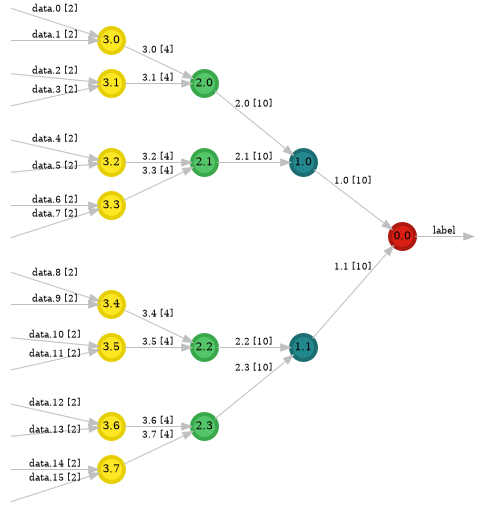

In [9]:
model.draw()

In [10]:
print(check_correct_init(model, atol=dtype_eps))
summary(model, input_size=(BATCH_SIZE, features, MAP_DIM), dtypes=[DTYPE], device=DEVICE)

(True, 0)


Layer (type:depth-idx)                   Output Shape              Param #
TTNModel                                 [5000, 5]                 3,268
Total params: 3,268
Trainable params: 3,268
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.64
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.64

## Train with global SGD

In [12]:
LR = .01
EPOCHS = 50
gauging = False
LAMBDA = 1e-4
SCHEDULER_STEPS = 5
LOSS = lambda *x: class_loss_fn(*x, l=LAMBDA) 

In [ ]:
model.train()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
if model.quantizer is not None:
    # define custom quantization functions for different numbers
    weight_quant = lambda x : fixed_point_quantize(x, wl, fl, rounding="nearest")
    # turn your optimizer into a low precision optimizer
    optimizer = OptimLP(optimizer,
                        weight_quant=weight_quant)

In [ ]:
schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False), torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)]
scheduler = schedulers[0]

In [ ]:

tot_loss_history = []
now = datetime.now()
for epoch in trange(EPOCHS, desc='epochs', position=0):
    loss_history = train_one_epoch(model, DEVICE, train_dl, LOSS, optimizer, gauging = gauging)
    tot_loss_history += loss_history

    if epoch % SCHEDULER_STEPS == SCHEDULER_STEPS-1:
        scheduler.step()
        #pass
   
loss_history = np.array(tot_loss_history)

## Train with sweeping

In [11]:
EPOCHS = 2
SWEEPS = 20
loss = lambda*x: class_loss_fn(*x, l=0.)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), 2**(model.n_layers-6)) #2**(model.n_layers-6)

if model.quantizer is not None:
    # define custom quantization functions for different numbers
    weight_quant = lambda x : fixed_point_quantize(x, wl, fl, rounding="nearest")
    # turn your optimizer into a low precision optimizer
    optimizer = OptimLP(optimizer,
                        weight_quant=weight_quant)

In [14]:
loss_history = []
grads_magnitude = []
now = datetime.now()
for s in trange(SWEEPS, desc='sweeps', position=0):

    losses, _ = model.sweep(train_dl, dclass_loss_fn, optimizer, epochs=EPOCHS, path_type='layer+0', manual=True, loss=loss, verbose=2, save_grads=False)
    loss_history.extend(losses)
    #grads_magnitude.extend(grads)

loss_history = np.array(loss_history)

sweeps:   0%|          | 0/20 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

ttn sweep:   0%|          | 0/18 [00:00<?, ?it/s]

epochs:   0%|          | 0/2 [00:00<?, ?it/s]

# Get performances

## Load model

### Quantized

In [3]:
from qtorch import FixedPoint, FloatingPoint
from qtorch.quant import Quantizer, fixed_point_quantize
from qtorch.optim import OptimLP

wl = 16
fl = 14

forward_num = FixedPoint(wl=wl, fl=fl)
backward_num = FixedPoint(wl=wl, fl=fl)

# Create a quantizer
Q = Quantizer(forward_number=forward_num, backward_number=backward_num,
              forward_rounding="nearest", backward_rounding="nearest")

DEVICE= 'cpu'
DTYPE = torch.float32
model = TTNModel.from_npz('trained_models/qmodels/model_hls_bd10_spin_20250211-165908.npz', device=DEVICE, dtype=DTYPE, quantizer=Q)

model.initialize(False)

In [4]:
x_train = np.load('trained_models/qmodels/x_train_hls_bd10_spin_20250211-165908.npy')
y_train = np.load('trained_models/qmodels/y_train_hls_bd10_spin_20250211-165908.npy')
x_test = np.load('trained_models/qmodels/x_test_hls_bd10_spin_20250211-165908.npy')
y_test = np.load('trained_models/qmodels/y_test_hls_bd10_spin_20250211-165908.npy')

train_out = np.load('trained_models/qmodels/train_out_hls_bd10_spin_20250211-165908.npy')
test_out = np.load('trained_models/qmodels/test_out_hls_bd10_spin_20250211-165908.npy')


In [5]:
(np.argmax(train_out, axis=1) == np.argmax(y_train, axis=1)).mean()

np.float64(0.2074646418238486)

In [11]:
pred = model(torch.as_tensor(x_train, dtype=torch.float32)).detach().numpy()

In [12]:
(np.argmax(train_out, axis=1) == np.argmax(pred, axis=1)).mean()

np.float64(1.0)

In [15]:
np.allclose(train_out, pred, atol=1e-4)

True

### Normal

In [ ]:

model_name = f'trained_models/{DATASET}_models/model_{DATASET}_bd10_spin_20241203-193144_betterweights'

MODEL_DIR = model_name.split('/')[0]+'/'
timestamp = model_name.split('_')[-1]
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TTNModel.from_npz(model_name+'.npz', device=DEVICE)
model.initialize(False)
BOND_DIM = model.bond_dim
N_LABELS = model.n_labels
DTYPE= model.dtype
#loss_history = np.load(model_name.split('/')[0] + '/loss_history_' + model_name.split('_')[-1] + '.npy')
#loss_history = np.load(model_name + '_loss.npy')
#now = datetime(int(timestamp[:4]), int(timestamp[4:6]), int(timestamp[6:8]), int(timestamp[9:11]), int(timestamp[11:13]), int(timestamp[13:15]))

### Grid search

In [ ]:
MODEL_DIR = 'data/search_entropy/'
id = 20
model_name = F'{MODEL_DIR}model_id{id}'
DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
model = TTNModel.from_npz(model_name+'.npz', device=DEVICE)
model.initialize(False)
BOND_DIM = model.bond_dim
N_LABELS = model.n_labels
DTYPE= model.dtype
loss_history = np.load('/'.join(model_name.split('/')[:-1]) + '/loss_history_' + model_name.split('_')[-1] + '.npy')

In [ ]:
model.draw()

## or not

In [15]:
accuracy(model, DEVICE, train_dl, test_dl, model.dtype)

test:   0%|          | 0/33 [00:00<?, ?it/s]

train:   0%|          | 0/129 [00:00<?, ?it/s]

(0.6381079805793898, 0.6395018191300461)

In [ ]:
model.normalize()
model.norm

In [ ]:
model.canonicalize('0.0')
model.draw()

In [16]:
#torch.save(model.state_dict, MODEL_DIR + f'/trainedmodel_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.dict')
np.save(MODEL_DIR + f'/loss_history_{now.strftime("%Y%m%d-%H%M%S")}.npy', loss_history)

### Plots

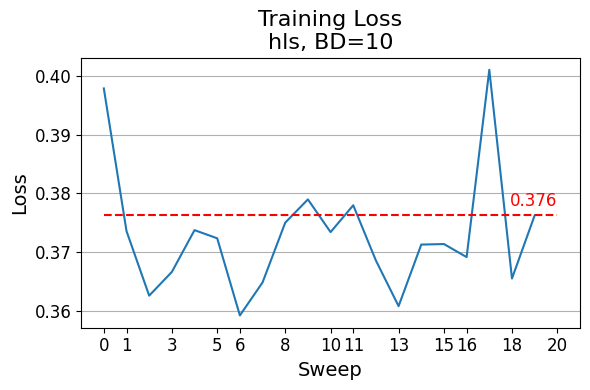

In [18]:
SWEEPS = 20
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax = plot_loss(loss_history, ax, SWEEPS, FS=FONTSIZE, sweep=True)
ax.set_title(F'Training Loss\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)
#ax.set_ylim(1150, 1240)
fig.tight_layout()
fig.savefig(MODEL_DIR + f'/loss_history_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.pdf') #_{now.strftime("%Y%m%d-%H%M%S")}

AttributeError: 'numpy.ndarray' object has no attribute 'legend'

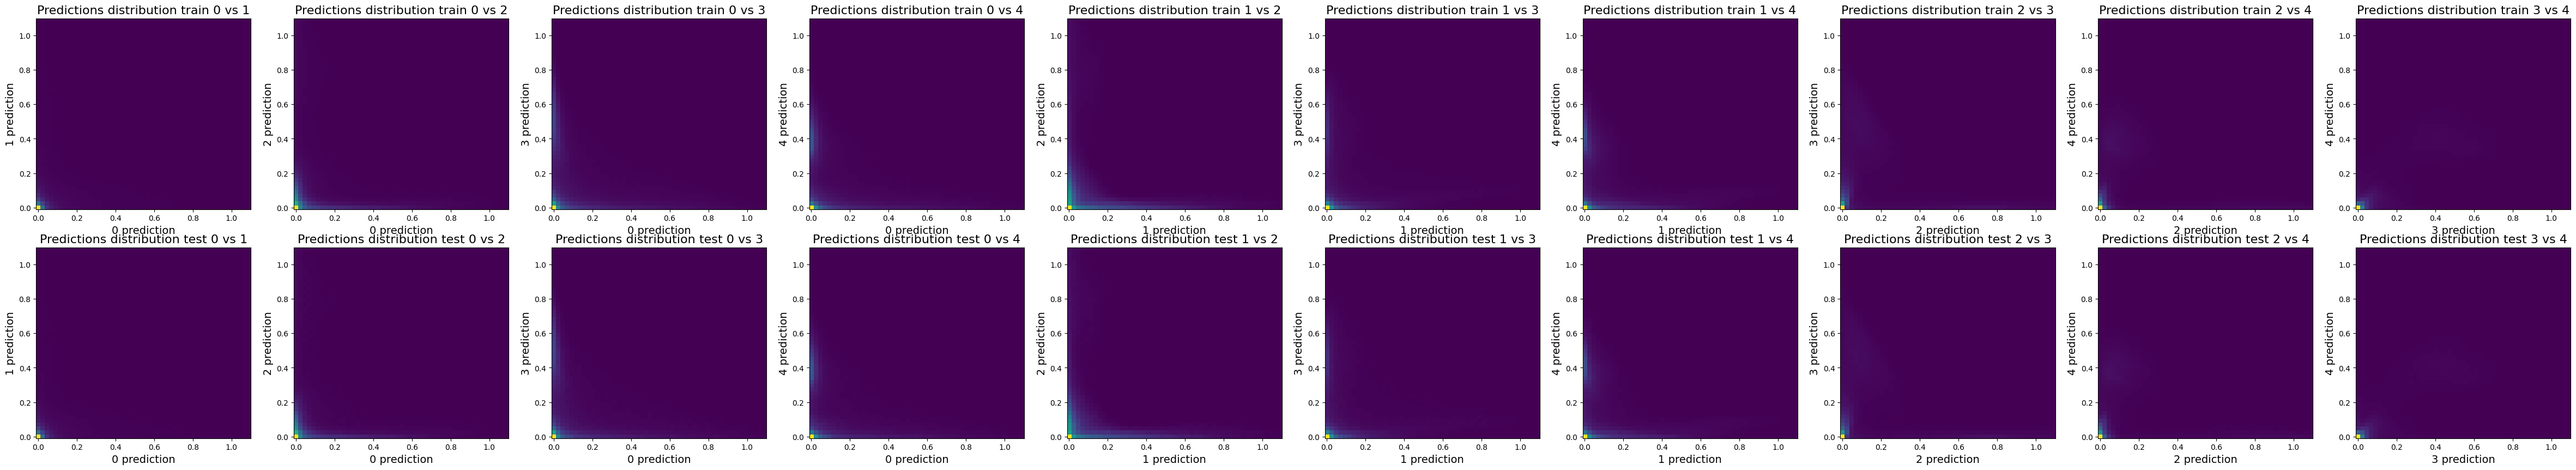

In [ ]:
y_train_true = torch.cat([y for _, y in train_dl], dim=0).to(dtype=torch.int).numpy()
y_test_true = torch.cat([y for _, y in test_dl], dim=0).numpy()

train_pred = get_predictions(model, DEVICE, train_dl)
test_pred = get_predictions(model, DEVICE, test_dl)
bins = np.linspace(-0.01, 1.1, 50)
fig, ax = plot_predictions(train_pred, test_pred, N_LABELS, nbins=bins, train_true=y_train_true, test_true=y_test_true, FS=FONTSIZE)

train_acc, test_acc = accuracy(model, DEVICE, train_dl, test_dl, DTYPE, disable_pbar=True)
legend_patches = []
legend_patches.append(patches.Rectangle([0,0], 0,0, facecolor='white', edgecolor='black', label=f'Train\nacc: {train_acc:.1%}'))
legend_patches.append(patches.Rectangle([0,0], 0,0, facecolor='white', edgecolor='black', hatch='//', label=f'Test\nacc: {test_acc:.1%}'))
legend_patches.append(patches.Rectangle([0,0], 0,0, color='tab:blue', alpha=0.6, label=r'$\bar S$'))
legend_patches.append(patches.Rectangle([0,0], 0,0, color='tab:orange', alpha=0.6, label=r'$S$'))



ax.legend(legend_patches, [patch.get_label() for patch in legend_patches])

ax.set_title(f'Predictions distribution\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)

fig.savefig(MODEL_DIR + f'/predictions_dist_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.png', dpi=600) #_{now.strftime("%Y%m%d-%H%M%S")}

In [ ]:
fig.suptitle(f'Predictions distribution\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)

fig.savefig(MODEL_DIR + f'/predictions_dist_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.pdf') #_{now.strftime("%Y%m%d-%H%M%S")}

In [ ]:
# save model output
train_out = get_output(model, DEVICE, train_dl)
test_out = get_output(model, DEVICE, test_dl)
np.save(MODEL_DIR + f'/train_out_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', train_out)
np.save(MODEL_DIR + f'/test_out_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', test_out)

In [21]:
train = np.concatenate([x for x, _ in train_dl])
test = np.concatenate([x for x, _ in test_dl])

np.save(MODEL_DIR + f'/x_train_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', train)
np.save(MODEL_DIR + f'/x_test_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', test)

np.save(MODEL_DIR + f'/y_train_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', y_train_true)
np.save(MODEL_DIR + f'/y_test_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', y_test_true)

### ROC

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_true.ravel(), test_pred.ravel())
auc = roc_auc_score(y_test_true, test_pred, multi_class='ovr', average='micro')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(fpr, tpr)
x = np.logspace(-12, 0, 100)
ax.plot(x, x, 'r--')
ax.text(0.84, 0.001, f'AUC = {auc:.2f}', fontsize=FONTSIZE-2, bbox=props, ha='right')
ax.set_xscale('log')
ax.set_xlim([1e-6, 1.0])
ax.set_xlabel('False Positive Rate', fontsize=FONTSIZE)
ax.set_ylabel('True Positive Rate', fontsize=FONTSIZE)
ax.set_title(f'ROC Curve\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
ax.grid()
fig.savefig(MODEL_DIR + f'/roc_curve_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.pdf') #_{now.strftime("%Y%m%d-%H%M%S")}

print('ROC AUC Score:', round(auc, 2))

In [ ]:
best_10 = np.argsort(tpr-fpr)[::-1][:10]
print(tpr[best_10], fpr[best_10], sep='\n')
thresholds[best_10]

In [ ]:
loadarff('../data/hls4ml_jets/hls4ml_HLF.arff')[0][:10]

In [ ]:
thresh = 0.5
fig, ax = plot_confusion_matrix(train_pred, y_train_true, [r'$g$', r'$W$', r'$t$', r'$Z$', r'$q$'], thresh=thresh)
ax.set_title(f'Train Confusion Matrix\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)
fig.tight_layout()
fig.savefig(MODEL_DIR + f'/train_confusion_matrix_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.pdf') #_{now.strftime("%Y%m%d-%H%M%S")}

fig, ax = plot_confusion_matrix(test_pred, y_test_true, [r'$g$', r'$W$', r'$t$', r'$Z$', r'$q$'], thresh=thresh)
ax.set_title(f'Test Confusion Matrix\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)
fig.tight_layout()
fig.savefig(MODEL_DIR + f'/test_confusion_matrix_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.pdf') #_{now.strftime("%Y%m%d-%H%M%S")}

In [ ]:
#save model weights
#np.savez(MODEL_DIR + f'/weights_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npz', **{key.name : value.cpu().detach() for key, value in model._TTN__tensor_map.items()})
model.to_npz(MODEL_DIR + f'/model_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npz')

### Correlations

In [ ]:
sz = torch.tensor([[1, 0], [0, -1]], dtype = DTYPE, device = DEVICE)

In [ ]:
feat_combos = combinations_with_replacement(np.arange(model.n_features), 2)
feat_combos = [combo for combo in feat_combos if combo[0] != combo[1]]
corr = np.empty((model.n_features, model.n_features, model.n_labels))
corr.fill(np.nan)

for combo in feat_combos:
    corr[combo] = model.expectation({TIndex(f'data.{i}', [f'data.{i}']): sz for i in combo}).cpu().numpy()

for n in range(model.n_features):
    corr[n, n] = model.expectation({TIndex(f'data.{n}', [f'data.{n}']): sz@sz}).cpu().numpy()


In [ ]:
def plot_correlations(corr, features, labels, fig=None, axs=None):
    n_feat = len(features)
    if axs is None:
        fig, axs = plt.subplots(1, len(labels), figsize=(n_feat*len(labels), n_feat))
    axs = np.atleast_1d(axs)
    for i, ax in enumerate(axs):
        im = ax.imshow(corr[:, :, i].T, cmap='coolwarm', vmin=-1, vmax=1, aspect='equal')
        ax.set_xticks(np.arange(n_feat), features, fontsize=FONTSIZE, rotation=45)
        ax.set_yticks(np.arange(n_feat), features, fontsize=FONTSIZE)
        # Minor ticks
        ax.set_xticks(np.arange(-.5, n_feat-1, 1), minor=True)
        ax.set_yticks(np.arange(-.5, n_feat-1, 1), minor=True)

        # Gridlines based on minor ticks
        ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
        #ax.set_xticklabels(features)
        #ax.set_yticklabels(features)
        ax.set_title(labels[i], fontsize=FONTSIZE+2)
        for n in range(n_feat):
            for m in range(n+1):
                text = ax.text(m, n, round(corr[m, n, i], 2), ha='center', va='center', color='black', fontsize=FONTSIZE-2)
    return fig, axs

In [ ]:
fig, axs = plot_correlations(corr, [i for i in range(16)], [r'$g$', r'$W$', r'$t$', r'$Z$', r'$q$'])
#fig.suptitle(r'$\sigma_z$ correlations between features', fontsize=FONTSIZE+2)
#fig.subplots_adjust()
fig.tight_layout()
fig.savefig(MODEL_DIR + f'/correlations_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.pdf') #_{now.strftime("%Y%m%d-%H%M%S")}

#fig.savefig('trenti_models/train_lhcb_bd8/correlations.png')

### Entropy

In [ ]:
model.canonicalize('0.0')

In [ ]:
feat_entropies = [value for key, value in model.get_entropies().items() if 'data' in key]
print('features entropies:', feat_entropies)
print('total feat entropy:', sum(feat_entropies))

In [ ]:
print('most informative features:', np.array([i for i in range(16)])[np.argsort(np.concatenate(feat_entropies))[::-1]])

In [ ]:
np.argsort(feat_entropies, axis=0)[:,0]

In [ ]:
list(zip(feat_entropies, titanic_features))

In [ ]:
feat_entropies_ordered, perm = np.sort(feat_entropies, axis=0), np.argsort(feat_entropies, axis=0)[:,0] 

fig, ax = plot_feat_en(feat_entropies_ordered, np.array([f'{i}' for i in range(16)])[perm], 'HLS', map_dim=MAP_DIM, FS=FONTSIZE, color='#647687')
fig.tight_layout()
fig.savefig(MODEL_DIR + f'/features_entropy_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.pdf') #_{now.strftime("%Y%m%d-%H%M%S")}

In [ ]:
def draw_mi(model, cmap='Reds'):
    mi = model.get_mi()
    cmap = colormaps.get_cmap('Reds')
    min, max = np.min(list(mi.values())), np.max(list(mi.values()))
    dot = graphviz.Digraph('Entropy', comment='TTN: ' + 'Entropy', engine='dot', format='svg', renderer='cairo', graph_attr={'bgcolour': 'transparent', 'rankdir': 'LR', 'splines':'false', 'size':'16,14', 'ratio':'compress', 'fontname':'Arial'})
    dot.attr('node', shape='circle', width='0.5', fixedsize='true', fontsize=str(11))
    dot.attr('edge', color='#bfbfbf', fontsize=str(11-2))
    dot.edge('0.0', 'hide', label=model.label_tag)
    dot.node('hide', '', shape='plaintext')
    for i, tindex in enumerate(model.indices):
        c_rgba = list(cmap((mi[tindex.indices[-1]]-min)/(max-min)))
        
        dot.node(tindex.name, tindex.name, fillcolor=colors.rgb2hex(c_rgba), style='filled', color = colors.rgb2hex(c_rgba), penwidth='4')
        
        dot.edge(tindex[0], tindex.name, label=str(tindex[0])+f' [{model.tensors[i].shape[0]}]', weight=str((int(tindex.name.split('.')[0])+1)**2))
        dot.edge(tindex[1], tindex.name, label=str(tindex[1])+f' [{model.tensors[i].shape[1]}]', weight=str((int(tindex.name.split('.')[0])+1)**2))

    for i in range(2**model.n_layers):
        index = f'data.{i}'
        c_rgba = list(cmap((mi[index]-min)/(max-min)))
        dot.node(index, index, fillcolor=colors.rgb2hex(c_rgba), style='filled', color = colors.rgb2hex(c_rgba), penwidth='4')

    return dot

def draw_entropy(model, features=None, labels=None, cmap='Reds'):
    entropies = model.get_entropies()
    n_labels = model.n_labels
    cmap = colormaps.get_cmap('Reds')
    min, max = np.min(np.stack(list(entropies.values())), axis=0), np.max(np.stack(list(entropies.values())), axis=0)
    print(min, max)
    dots = []

    for j in range(n_labels):

        dot = graphviz.Digraph('Entropy', comment='TTN: ' + 'Entropy', engine='dot', format='svg', renderer='cairo', graph_attr={'bgcolour': 'transparent', 'rankdir': 'LR', 'splines':'false', 'size':'8,6', 'ratio':'compress', 'fontname':'Arial'})
        dot.attr('node', shape='circle', width='0.5', fixedsize='true', fontsize=str(11))
        dot.attr('edge', color='#bfbfbf', fontsize=str(11-2))
        dot.edge('0.0', 'hide', label=model.label_tag if labels is None else labels[j])
        dot.node('hide', '', shape='plaintext')
        for i, tindex in enumerate(model.indices):
            c_rgba = (0,0,0,0) if tindex.indices[-1] == 'label' else list(cmap((entropies[tindex.indices[-1]][j]-min[j])/(max[j]-min[j])))
            
            dot.node(tindex.name, tindex.name, fillcolor=colors.rgb2hex(c_rgba), style='filled', color = colors.rgb2hex(c_rgba), penwidth='4')
            
            dot.edge(tindex[0], tindex.name, label=str(tindex[0])+f' [{model.tensors[i].shape[0]}]', weight=str((int(tindex.name.split('.')[0])+1)**2))
            dot.edge(tindex[1], tindex.name, label=str(tindex[1])+f' [{model.tensors[i].shape[1]}]', weight=str((int(tindex.name.split('.')[0])+1)**2))

        for i in range(2**model.n_layers):
            index = f'data.{i}'
            c_rgba = list(cmap((entropies[index][j]-min[j])/(max[j]-min[j])))
            dot.node(index, index if features is None else features[i], fillcolor=colors.rgb2hex(c_rgba), style='filled', color = colors.rgb2hex(c_rgba), penwidth='4')
        dots.append(dot)

    return dots

In [ ]:
dot = draw_mi(model)
dot

In [ ]:
model.get_entropies()

In [ ]:
dots = draw_entropy(model, features=None)
for i, dot in enumerate(dots):
    display(SVG(dot.pipe(format='svg')))
    dot.render(MODEL_DIR + f'/entropy_{DATASET}_bd{BOND_DIM}_{MAPPING}_l{i}_{now.strftime("%Y%m%d-%H%M%S")}', format='pdf', cleanup=True)
    #dot.render('trenti_models/train_lhcb_bd8/entropy_l' + str(i), format='svg', cleanup=True)
    

In [ ]:
dot.render(MODEL_DIR + f'/mi_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}', format='png', cleanup=True)

In [ ]:
svg = skunk.layout_svgs([MODEL_DIR + f'/entropy_{DATASET}_bd{BOND_DIM}_{MAPPING}_l{i}_{now.strftime("%Y%m%d-%H%M%S")}.cairo.svg' for i in range(model.n_labels)],
                        #labels=['Iris-virginica', 'Iris-versicolor', 'Iris-setosa'],
                        shape=(1, 3), figsize=(20, 6), fontsize=FONTSIZE+2)

In [ ]:
skunk.display(svg)

In [ ]:
with open('entropy.svg', 'w') as f:
    f.write(svg)

In [ ]:
data = []
labels = []

for x, y in train_dl:
    data.append(x)
    labels.append(y)

for x, y in test_dl:
    data.append(x)
    labels.append(y)

data = torch.cat(data, dim=0)
labels = torch.cat(labels, dim=0)

#np.save(MODEL_DIR + f'/data_{DATASET}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', data)
#np.save(MODEL_DIR + f'/labels_{DATASET}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', labels)

In [ ]:
plt.hist(data[:,np.nonzero(np.array(titanic_features) == 'age')[0][0], 0].flatten())

## Get weights distribution

In [ ]:
def get_weights_population(n, dataloader, disable_pbar=False, **kws):
    weights_ls = []
    DEVICE = 'cuda'
    BATCH_SIZE = 64
    DTYPE = torch.double
    INIT_EPOCHS = 5
    LR = 0.05
    EPOCHS = 80
    SCHEDULER_STEPS = 4
    train_dl, test_dl, features = dataloader(batch_size=BATCH_SIZE, **kws)

    label_shape = next(iter(train_dl))[1].shape
    N_LABELS = 1 if len(label_shape) == 1 else label_shape[1]
    
    pbar = tqdm(total=n*EPOCHS*len(train_dl), position=0, desc='weights population', leave=True, disable=disable_pbar)
    for _ in range(n):        
        model = TTNModel(features, bond_dim=BOND_DIM, n_labels=N_LABELS, device=DEVICE, dtype=DTYPE)
        model.initialize(True, train_dl, class_loss, INIT_EPOCHS, disable_pbar=True)
        model.train()
        model.to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
        schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False), torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)]
        scheduler = schedulers[0]
        tot_loss_history = []
        for epoch in range(EPOCHS):
            loss_history = train_one_epoch(model, DEVICE, train_dl, class_loss, optimizer, pbar=pbar, disable_pbar=disable_pbar)
            tot_loss_history += loss_history
            if epoch % SCHEDULER_STEPS == SCHEDULER_STEPS-1:
                scheduler.step()

        loss_history = np.array(tot_loss_history)
        print('Accuracy on train and test set:', accuracy(model, DEVICE, train_dl, test_dl, DTYPE, disable_pbar=True))

        weights = [tensor.detach().cpu().flatten() for tensor in model.tensors]
        weights_ls.append(torch.concat(weights, dim=0))
        train_dl, test_dl, h = dataloader(batch_size=BATCH_SIZE, **kws)
    return torch.stack(weights_ls)

In [ ]:
BOND_DIM = 10
weights = get_weights_population(5, get_titanic_data_loaders)

In [ ]:
weights_plt = weights.flatten().numpy()
#np.save(f'models/weights_{BOND_DIM}_{now.strftime("%Y%m%d-%H%M%S")}.npy', weights.numpy())
FS = 16
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(weights_plt, bins=40)
ax.set_xlabel('Weight', fontsize=FS)
ax.set_ylabel('Counts', fontsize=FS)
ax.set_title('Weights Distribution', fontsize=FS+2)
ax.tick_params(axis='both', which='major', labelsize=FS-2)
#ax.set_yticklabels(ax.get_yticks(), fontsize=FS-2)

#fig.savefig(f'models/weight_distribution_{BOND_DIM}_{now.strftime("%Y%m%d-%H%M%S")}.svg')

In [123]:
weights = [tensor.detach().cpu().flatten() for tensor in qmodel.tensors[3:7]]
weights = torch.concat(weights, dim=0)
weights

tensor([-6.1993e-01,  7.7502e-01,  1.2180e+00, -3.2434e-01, -5.5487e-01,
         3.1323e-01, -1.0759e+00,  2.4701e-01,  5.5603e-02,  4.7961e-01,
         6.0840e-01, -4.5355e-01, -3.2141e-01,  4.8090e-01, -3.3203e-01,
         6.3141e-01,  2.4451e-01,  7.3523e-01, -1.4020e-01, -1.7371e-01,
        -5.4089e-01, -5.2118e-01,  7.8918e-02,  2.8998e-01,  2.5903e-01,
         5.2307e-02, -3.5815e-01, -1.7432e-01, -7.9651e-02,  1.5405e-01,
         3.4448e-01, -4.1473e-01, -7.9126e-01,  7.4646e-02,  2.2827e-02,
         1.5155e-01,  2.3267e-01, -2.6306e-02,  1.1658e-01, -2.1503e-01,
        -1.6407e+00,  8.3484e-01, -1.4282e-01, -1.1131e+00, -2.5391e-02,
         6.6309e-01, -7.5391e-01,  1.6522e-01, -1.0059e-01, -3.7115e-01,
         2.4548e-01, -6.0449e-01, -3.9471e-01,  1.4130e-01,  2.3944e-01,
        -1.6992e-01,  2.7472e-01,  1.2897e-01,  3.1683e-01,  2.5177e-01,
        -8.1360e-01, -1.0400e-01, -2.1906e-01, -4.2090e-01,  2.5342e-01,
        -1.5472e-01,  1.8610e-01, -4.7467e-01,  2.7

In [124]:
(weights < 0.0001).mean(dtype=torch.float)

tensor(0.4984)

(array([ 1.,  0.,  1.,  0.,  3.,  3.,  5.,  5.,  4.,  4., 10.,  8., 13.,
        14., 25., 29., 40., 59., 63., 83., 70., 62., 35., 29., 20., 15.,
        10.,  6.,  5.,  4.,  4.,  3.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,
         2.]),
 array([-1.86724854, -1.77062833, -1.67400813, -1.57738805, -1.48076785,
        -1.38414764, -1.28752744, -1.19090724, -1.09428716, -0.9976669 ,
        -0.90104675, -0.80442655, -0.70780635, -0.61118615, -0.51456606,
        -0.41794586, -0.32132566, -0.22470546, -0.12808526, -0.03146517,
         0.06515503,  0.16177535,  0.25839543,  0.35501552,  0.45163584,
         0.54825592,  0.64487624,  0.74149632,  0.83811641,  0.93473673,
         1.03135681,  1.12797713,  1.22459722,  1.3212173 ,  1.41783762,
         1.5144577 ,  1.61107802,  1.70769811,  1.80431819,  1.90093851,
         1.99755859]),
 <BarContainer object of 40 artists>)

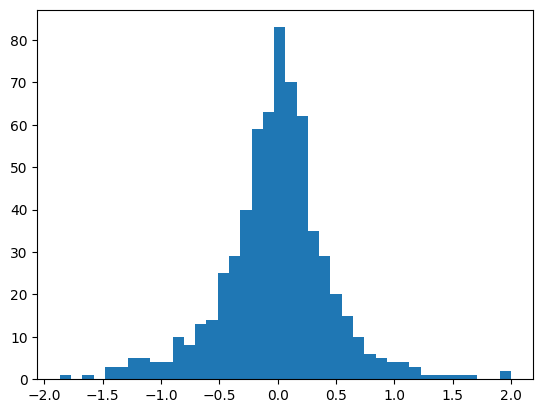

In [125]:
plt.hist(weights, bins=40)

In [118]:
print('min', np.abs(weights.numpy()).min(), 'max', np.abs(weights.numpy()).max(), sep='\n')

min
0.0
max
1.3788452


In [ ]:
print('min', np.abs(weights.numpy()).min(axis=1).mean(), 'max', np.abs(weights.numpy()).max(axis=1).mean(), sep='\n')

In [ ]:
mins = [tensor.abs().min().item() for tensor in model.tensors]
maxs = [tensor.abs().max().item() for tensor in model.tensors]
means = [tensor.mean().item() for tensor in model.tensors]

print('mins:', mins, 'maxs:', maxs, 'means:', means, sep='\n')

## Rescale weights

In [ ]:
tensors = [tensor.detach().cpu() for tensor in model.tensors]

In [ ]:
tensors[0].norm(dim=(0, 1))

In [ ]:
del model._TTN__tensors
model.tensors = tensors

In [ ]:
layer = 2
new_tensors = []
for i in range(2**layer):
    new_tensors.append(model[f'{layer}.{i}']*2)

model.tensors = model.tensors[:2**layer-1] + new_tensors + model.tensors[2**(layer+1)-1:2**model.n_layers-1]


In [ ]:
model.tensors[0] /= 2**layer

In [ ]:
model.to_npz('trained_models/hls_models/model_hls_bd10_spin_20250211-155234_betterweights3.npz')

In [130]:
accuracy(qmodel, DEVICE, train_dl, test_dl, DTYPE)

test:   0%|          | 0/33 [00:00<?, ?it/s]

train:   0%|          | 0/129 [00:00<?, ?it/s]

(0.7308370481665901, 0.7305266164181143)

In [106]:
# save model output
train_out = get_output(qmodel, DEVICE, train_dl, DTYPE)
test_out = get_output(qmodel, DEVICE, test_dl, DTYPE)
np.save(MODEL_DIR + f'/train_out_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', train_out)
np.save(MODEL_DIR + f'/test_out_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', test_out)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8ad93b370>
Traceback (most recent call last):
  File "/home/ubuntu/data/ttn4hep/.ttn_venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/data/ttn4hep/.ttn_venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8ad93b370>
Traceback (most recent call last):
  File "/home/ubuntu/data/ttn4hep/.ttn_venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/data/ttn4hep/.ttn_venv/lib/python3.10/site-packages/tor

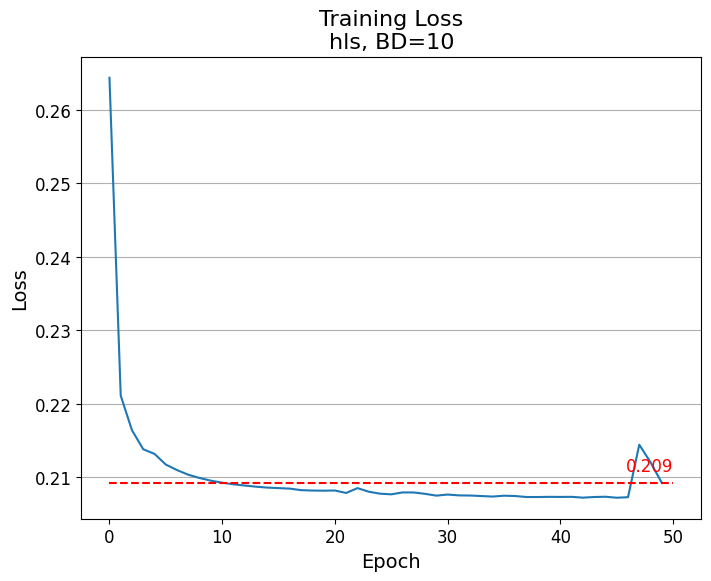

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot([loss_history[i*len(train_dl):((i+1)*len(train_dl) if i<EPOCHS-1 else None)].mean() for i in range(EPOCHS)])
#ax.set_ylim(0, 0.3)
ax.set_xlabel('Epoch', fontsize=FONTSIZE)
ax.set_ylabel('Loss', fontsize=FONTSIZE)
ax.set_title(F'Training Loss\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
ax.grid(axis='y')

ax.hlines(loss_history[(EPOCHS-1)*len(train_dl):].mean(), 0, EPOCHS, colors='r', linestyles='dashed')
ax.text(EPOCHS, loss_history[(EPOCHS-1)*len(train_dl):].mean()+0.001, f'{loss_history[(EPOCHS-1)*len(train_dl):].mean():.3f}', fontsize=FONTSIZE-2, color='r', verticalalignment='bottom', horizontalalignment='right')

fig.savefig(MODEL_DIR + f'/loss_history_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.png')

AttributeError: 'numpy.ndarray' object has no attribute 'legend'

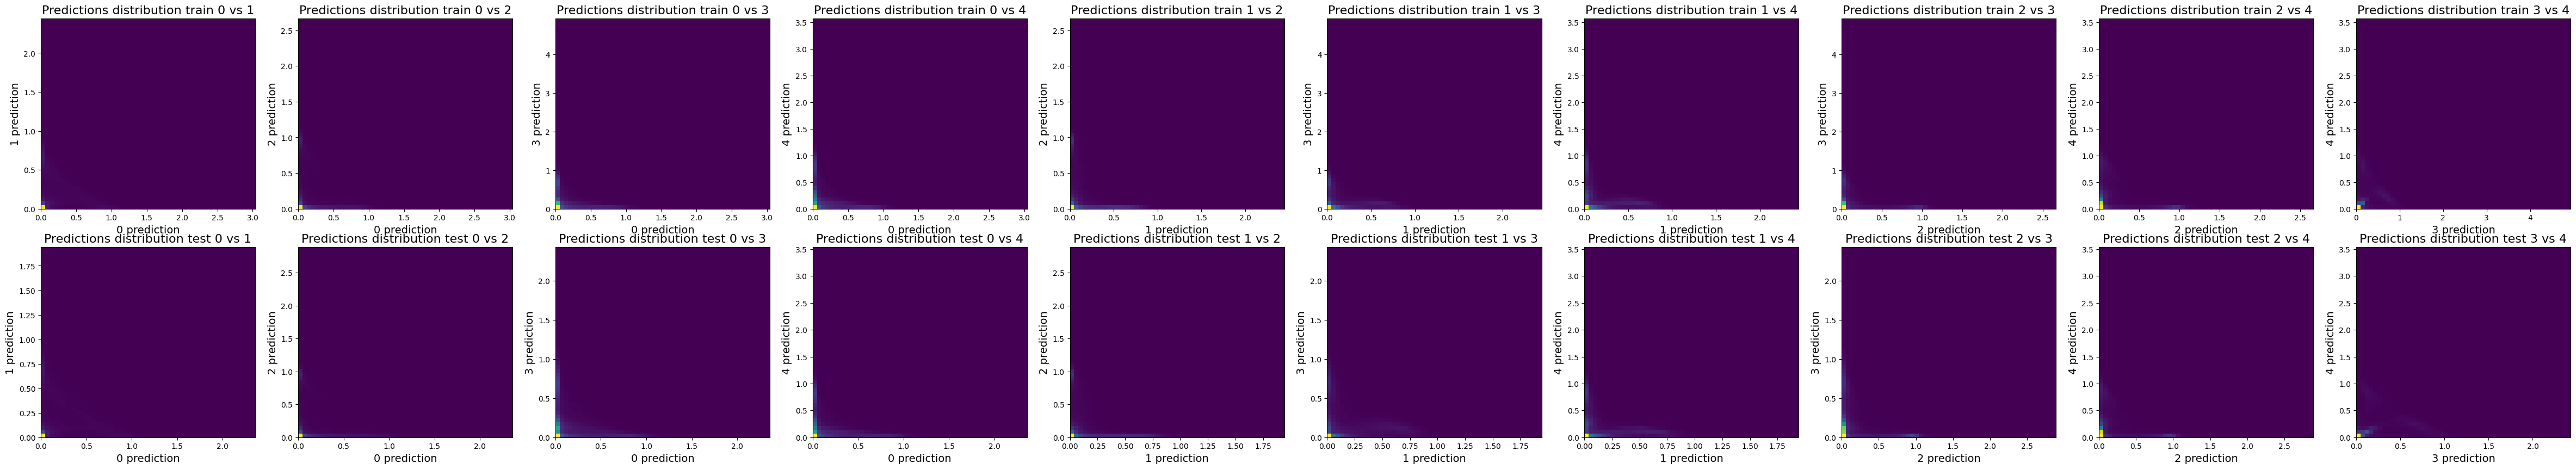

In [108]:
train_pred = get_predictions(qmodel, DEVICE, train_dl, DTYPE)
test_pred = get_predictions(qmodel, DEVICE, test_dl, DTYPE)

fig, ax = plot_predictions(train_pred, test_pred, N_LABELS)

train_acc, test_acc = accuracy(qmodel, DEVICE, train_dl, test_dl, DTYPE, disable_pbar=True)

ax.legend([f'Train\nacc: {train_acc:.1%}', f'Test\nacc: {test_acc:.1%}'])
ax.set_title(f'Predictions distribution\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)

fig.savefig(MODEL_DIR + f'/predictions_dist_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.png')

In [109]:
qmodel.to_npz(MODEL_DIR + f'/model_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npz')

In [ ]:
y_test_true = torch.cat([y for _, y in test_dl], dim=0).numpy()
y_train_true = torch.cat([y for _, y in train_dl], dim=0).numpy()

ROC AUC Score: 0.91


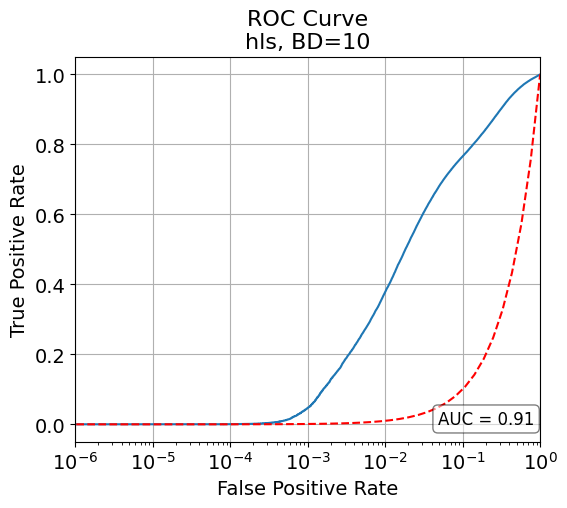

In [129]:
fpr, tpr, thresholds = roc_curve(y_test_true.ravel(), test_pred.ravel())
auc = roc_auc_score(y_test_true, test_pred, multi_class='ovr', average='micro')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(fpr, tpr)
x = np.logspace(-12, 0, 100)
ax.plot(x, x, 'r--')
ax.text(0.84, 0.001, f'AUC = {auc:.2f}', fontsize=FONTSIZE-2, bbox=props, ha='right')
ax.set_xscale('log')
ax.set_xlim([1e-6, 1.0])
ax.set_xlabel('False Positive Rate', fontsize=FONTSIZE)
ax.set_ylabel('True Positive Rate', fontsize=FONTSIZE)
ax.set_title(f'ROC Curve\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
ax.grid()
fig.savefig(MODEL_DIR + f'/roc_curve_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.pdf') #_{now.strftime("%Y%m%d-%H%M%S")}

print('ROC AUC Score:', round(auc, 2))

In [ ]:
tensors = torch.load('qmodels/trainedmodel_titanic_bd4_spin_20240213-140002.dict')()
list(tensors.values())[0].shape

In [ ]:
tensors = np.load('qmodels/modelweights_titanic_bd4_spin_20240213-140002.npz')
list(tensors.values())[0].shape

In [ ]:
qmodel.tensors = [torch.tensor(tensor).to(dtype=torch.float, device='cuda') for tensor in tensors.values()]

In [ ]:
qmodel['2.0']['2.0'].shape

In [ ]:
data = np.load('titanic_models/data_titanic_spin_20240213-134127.npy')
data = torch.tensor(data[:16], dtype=torch.float, device='cuda')
data

In [ ]:
qmodel.draw()

In [ ]:
branch = '2.0'
qmodel._propagate_data_through_branch_({TIndex(f'data.{i}', [f'data.{i}']): data[:, i] for i in range(2)}, qmodel.get_branch(branch), keep=True)

In [ ]:
contract_up(qmodel[branch][branch], data[:2], quantizer=Q)

In [ ]:
quantizer = Q
tensor = qmodel[branch][branch]
data_tensors = data[:1,:2].transpose(0, 1)
tensor = quantizer(tensor)
left   = quantizer(torch.matmul(quantizer(data_tensors[0]), tensor.contiguous().view(tensor.shape[0], -1)))
right  = quantizer(torch.bmm(quantizer(data_tensors[1]).unsqueeze(1), left.view(-1, tensor.shape[1], tensor.shape[2])))

In [ ]:
tensor
left

In [ ]:
print('tensor:', tensor.permute(2, 0, 1))
print('left:', left)
print('right:', right)
print('data0:', quantizer(data_tensors[0]))
print('data1:', quantizer(data_tensors[1]))

In [ ]:
print(qmodel['2.0']['2.0'][-1, -1, -1].item())

# Trash

In [ ]:
torch.load('data/grid_search/model_8_4_16_False_torch.float64.pth')['_TTN__tensors.0']

In [ ]:
data_arff = arff.load(open('../data/titanic/titanic.arff', 'r'))
dataframe = pd.DataFrame(data_arff['data'])
dataframe.columns = [x[0] for x in data_arff['attributes']]
dataframe.drop(columns=['name', 'cabin', 'body', 'boat', 'home.dest'], inplace=True)
dataframe.dropna(inplace=True)
dataframe.to_csv('../data/titanic/titanic.csv', index=False)
dataframe

In [ ]:
path = '../data'
train = torch.tensor(np.load(path + '/Higgs/higgs_train.npy'))
permutation = torch.randperm(train.shape[1])
train[:, permutation]

In [ ]:
torch.randperm(train.shape[1]).tolist()

In [ ]:
[np.random.permutation(4) for _ in range(5)]